<a href="https://colab.research.google.com/github/Alisser2001/QuantumMachineLearning/blob/emmadev/LOFBaseballQML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd

# URL del archivo raw en GitHub
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/baseball.dat"

# Descargar el contenido del archivo
response = requests.get(url)
lines = [line.strip() for line in response.text.splitlines()]

# Extraer atributos
attributes = [line.split()[1] for line in lines if line.startswith("@attribute")]

# Extraer datos (después de @data)
data_start = lines.index("@data") + 1
data = [line.split(",") for line in lines[data_start:] if line]

# Crear DataFrame
df = pd.DataFrame(data, columns=attributes).astype(float)

print(df.head())


   Batting_average  On-base_percentage   Runs   Hits  Doubles  Triples  \
0            0.271               0.328   74.0  161.0     22.0      6.0   
1            0.264               0.318   24.0   48.0      7.0      0.0   
2            0.251               0.338  101.0  141.0     35.0      3.0   
3            0.224               0.274   28.0   94.0     21.0      1.0   
4            0.206               0.262   14.0   51.0     18.0      1.0   

   HomeRuns  Runs_batted_in  Walks  Strike-Outs  Stolen_bases  Errors  \
0      12.0            58.0   49.0        133.0          23.0    17.0   
1       1.0            22.0   15.0         18.0           0.0     7.0   
2      32.0           105.0   71.0        104.0          34.0     6.0   
3       1.0            44.0   27.0         54.0           2.0     7.0   
4       1.0            28.0   17.0         26.0           0.0     3.0   

   Free_agency_eligibility  Free_agent  Arbitration_eligibility  Arbitration  \
0                      1.0         1

In [2]:
# =========================
# SETUP: paleta 'pastel' (nativa de seaborn)
# =========================
import math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

palette_name = "pastel"
sns.set_theme(style="whitegrid", context="notebook", palette=palette_name, font_scale=1.05)
pal = sns.color_palette(palette_name)

# colores explícitos extraídos de la paleta
color_main  = pal[2]    # para histogramas / puntos
color_kde   = pal[1]    # para KDE / líneas suaves
color_accent= pal[-1]   # para líneas de regresión o destaque
box_color   = pal[0]    # para boxplots inset

print("Paleta aplicada:", palette_name, " — Colores:", pal)


Paleta aplicada: pastel  — Colores: [(0.6313725490196078, 0.788235294117647, 0.9568627450980393), (1.0, 0.7058823529411765, 0.5098039215686274), (0.5529411764705883, 0.8980392156862745, 0.6313725490196078), (1.0, 0.6235294117647059, 0.6078431372549019), (0.8156862745098039, 0.7333333333333333, 1.0), (0.8705882352941177, 0.7333333333333333, 0.6078431372549019), (0.9803921568627451, 0.6901960784313725, 0.8941176470588236), (0.8117647058823529, 0.8117647058823529, 0.8117647058823529), (1.0, 0.996078431372549, 0.6392156862745098), (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]


In [3]:
# Vista rápida de los datos
print("Dimensiones:", df.shape)
print("\nPrimeras filas:")
display(df.head())

print("\nDescripción estadística:")
display(df.describe().T)

print("\nValores nulos por columna:")
print(df.isnull().sum())

print("\nTipo de datos por columna:")
print(df.dtypes)

Dimensiones: (337, 17)

Primeras filas:


,Batting_average,On-base_percentage,Runs,Hits,Doubles,Triples,HomeRuns,Runs_batted_in,Walks,Strike-Outs,Stolen_bases,Errors,Free_agency_eligibility,Free_agent,Arbitration_eligibility,Arbitration,Salary
0,0.271,0.328,74.0,161.0,22.0,6.0,12.0,58.0,49.0,133.0,23.0,17.0,1.0,1.0,0.0,0.0,109.0
1,0.264,0.318,24.0,48.0,7.0,0.0,1.0,22.0,15.0,18.0,0.0,7.0,0.0,0.0,0.0,0.0,160.0
2,0.251,0.338,101.0,141.0,35.0,3.0,32.0,105.0,71.0,104.0,34.0,6.0,0.0,0.0,1.0,0.0,2700.0
3,0.224,0.274,28.0,94.0,21.0,1.0,1.0,44.0,27.0,54.0,2.0,7.0,1.0,1.0,0.0,0.0,550.0
4,0.206,0.262,14.0,51.0,18.0,1.0,1.0,28.0,17.0,26.0,0.0,3.0,1.0,1.0,0.0,0.0,300.0



Descripción estadística:


,count,mean,std,min,25%,50%,75%,max
Batting_average,337.0,0.257825,0.039546,0.063,0.238,0.260,0.281,0.457
On-base_percentage,337.0,0.323973,0.047132,0.063,0.297,0.323,0.354,0.486
Runs,337.0,46.697329,29.020166,0.000,22.000,41.000,69.000,133.000
Hits,337.0,92.833828,51.896322,1.000,51.000,91.000,136.000,216.000
Doubles,337.0,16.673591,10.452001,0.000,9.000,15.000,23.000,49.000
Triples,337.0,2.338279,2.543336,0.000,0.000,2.000,3.000,15.000
HomeRuns,337.0,9.097923,9.289934,0.000,2.000,6.000,15.000,44.000
Runs_batted_in,337.0,44.020772,29.559406,0.000,21.000,39.000,66.000,133.000
Walks,337.0,35.017804,24.842474,0.000,15.000,30.000,49.000,138.000
Strike-Outs,337.0,56.706231,33.828784,1.000,31.000,49.000,78.000,175.000



Valores nulos por columna:
Batting_average            0
On-base_percentage         0
Runs                       0
Hits                       0
Doubles                    0
Triples                    0
HomeRuns                   0
Runs_batted_in             0
Walks                      0
Strike-Outs                0
Stolen_bases               0
Errors                     0
Free_agency_eligibility    0
Free_agent                 0
Arbitration_eligibility    0
Arbitration                0
Salary                     0
dtype: int64

Tipo de datos por columna:
Batting_average            float64
On-base_percentage         float64
Runs                       float64
Hits                       float64
Doubles                    float64
Triples                    float64
HomeRuns                   float64
Runs_batted_in             float64
Walks                      float64
Strike-Outs                float64
Stolen_bases               float64
Errors                     float64
Free_agency_eligib

confirmamos que no hay valores nulos y que todos son números, por lo tanto no es necesario pensar en una transformación ni en una imputación de datos

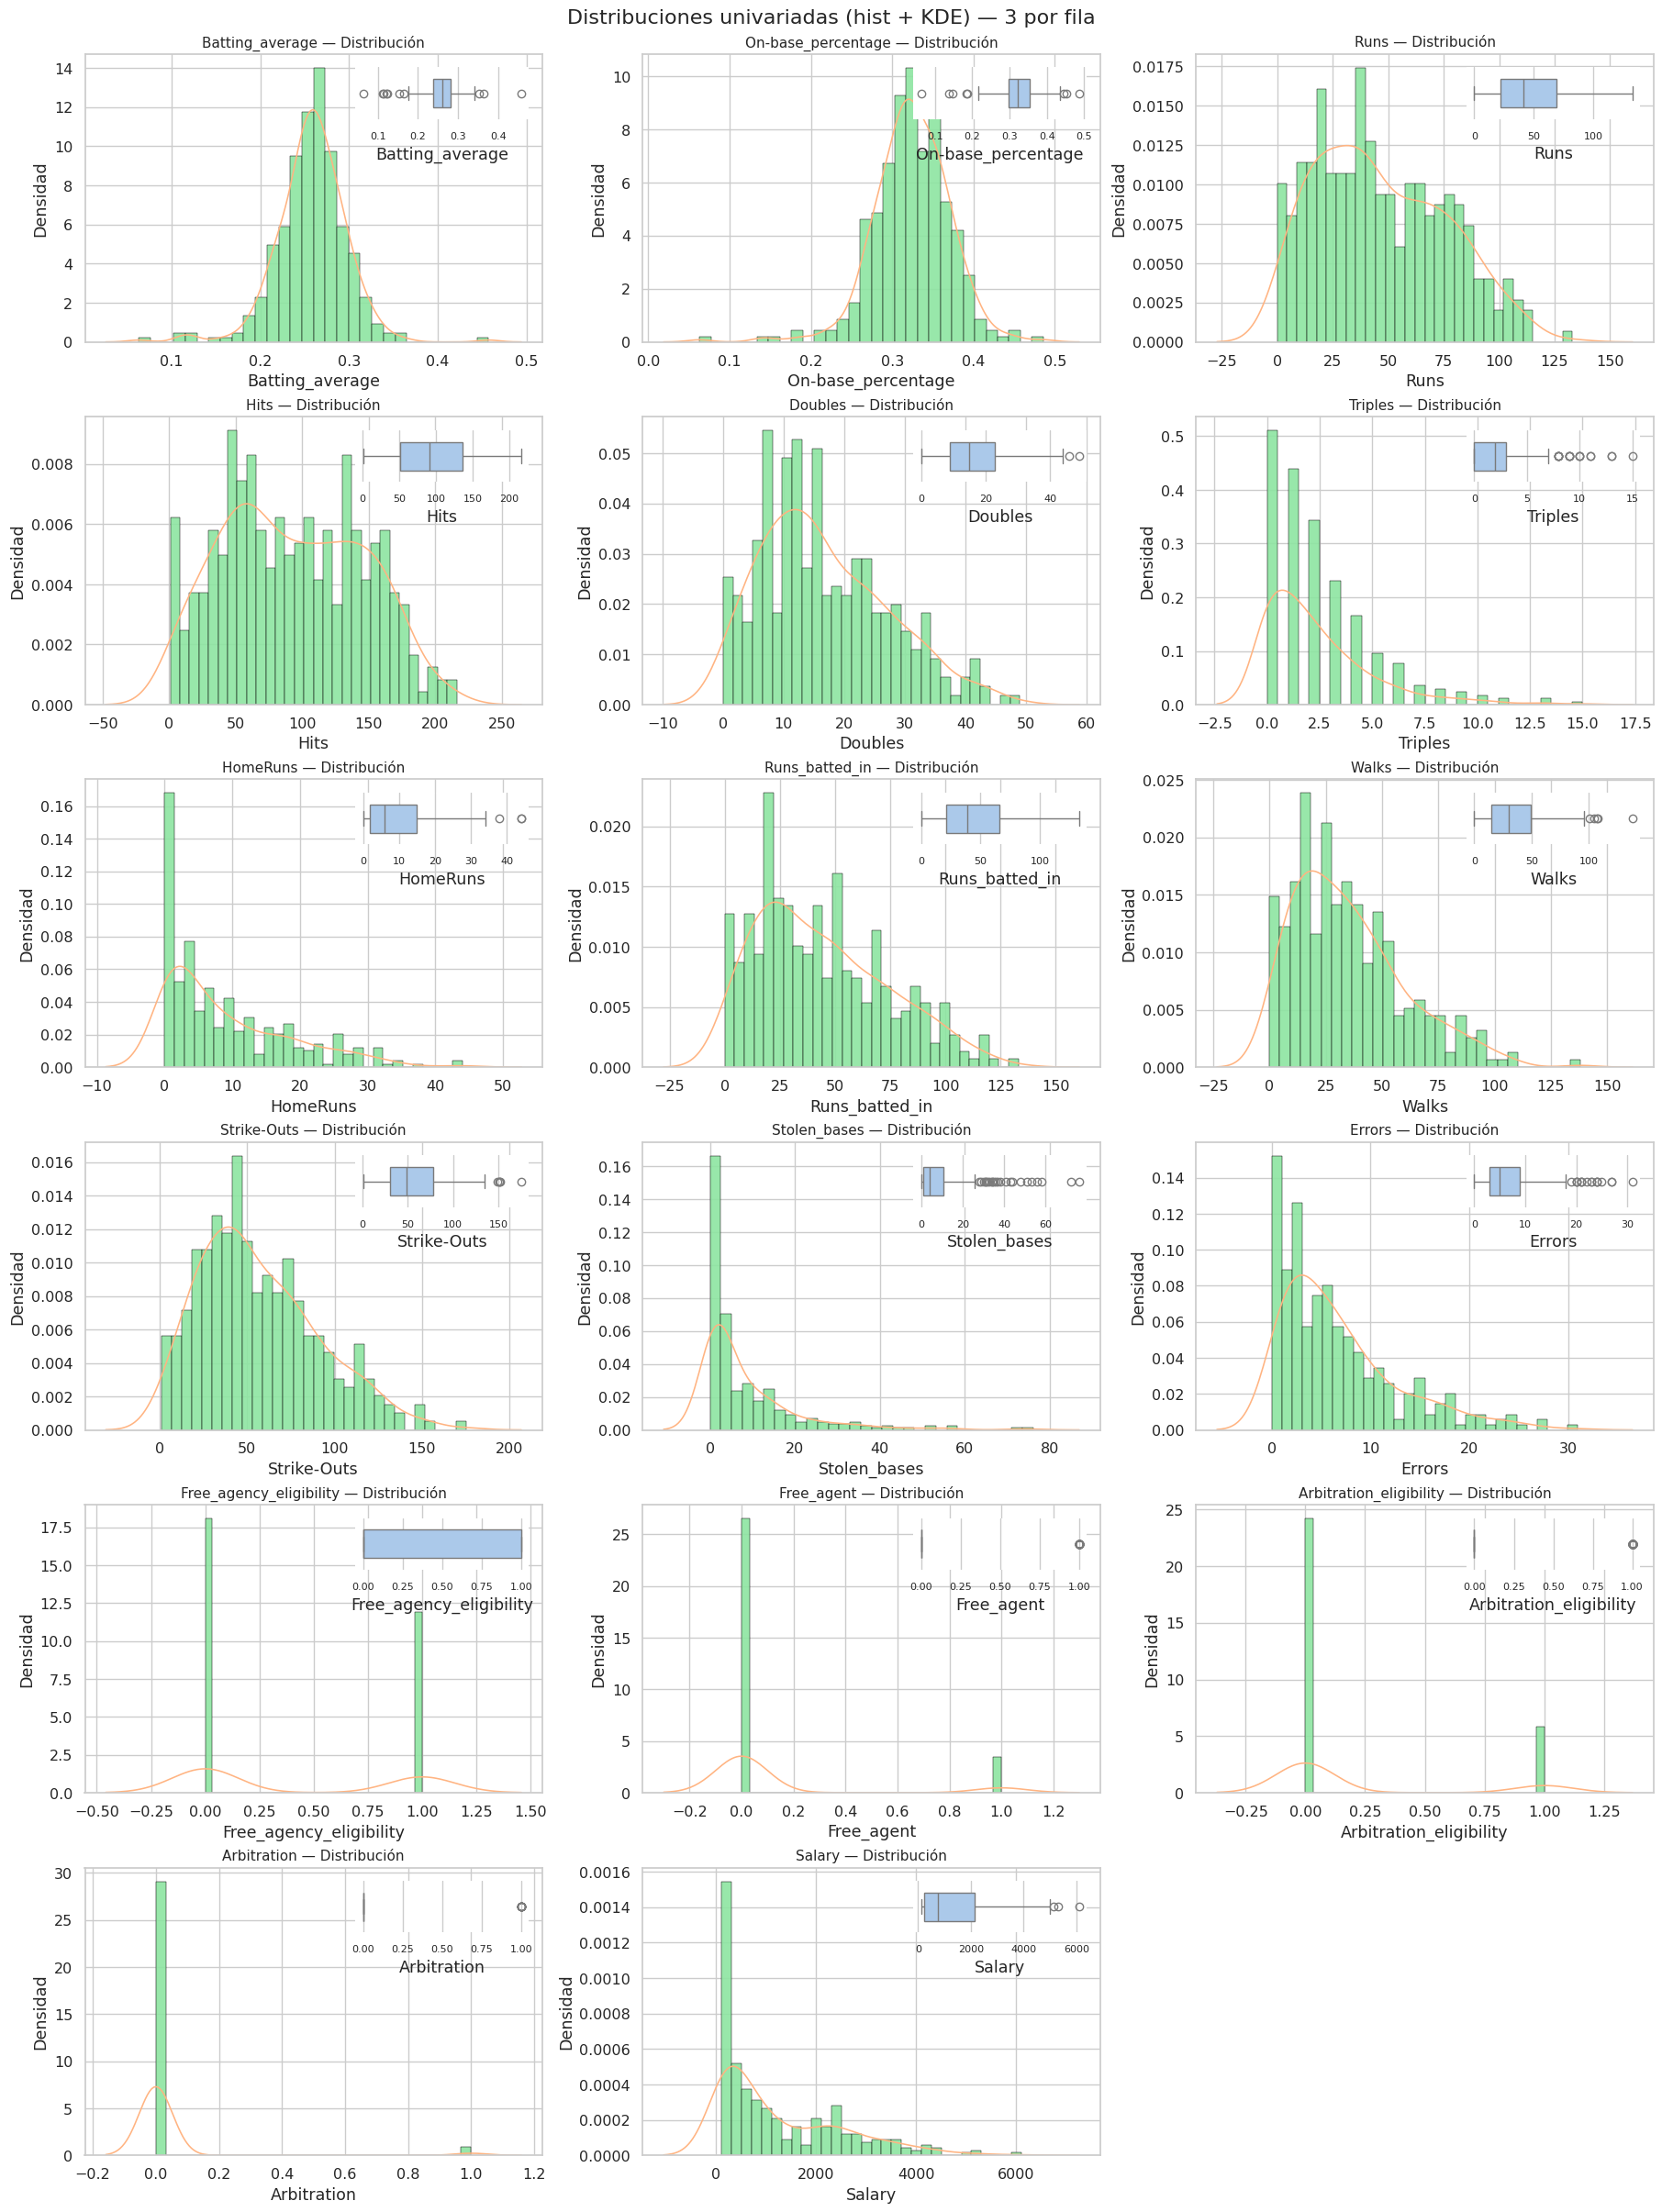

In [4]:
cols = df.columns.tolist()
n = len(cols)
cols_per_row = 3
rows = math.ceil(n / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, 4*rows), constrained_layout=True)
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    sns.histplot(df[col], kde=False, bins=30, ax=ax, stat="density",
                 color=color_main, edgecolor="black", linewidth=0.35, alpha=0.9)
    sns.kdeplot(df[col], ax=ax, color=color_kde, linewidth=1.15)
    ax.set_title(f"{col} — Distribución", fontsize=11)
    ax.set_ylabel("Densidad")

    axins = inset_axes(ax, width="38%", height="18%", loc='upper right', borderpad=0.9)
    sns.boxplot(x=df[col], ax=axins, orient="h", width=0.55, color=box_color)
    axins.set_yticks([])
    axins.tick_params(axis='both', which='both', labelsize=8)
    for spine in axins.spines.values():
        spine.set_visible(False)

for j in range(n, rows*cols_per_row):
    fig.delaxes(axes[j])


fig.suptitle("Distribuciones univariadas (hist + KDE) — 3 por fila", fontsize=16)

plt.show()


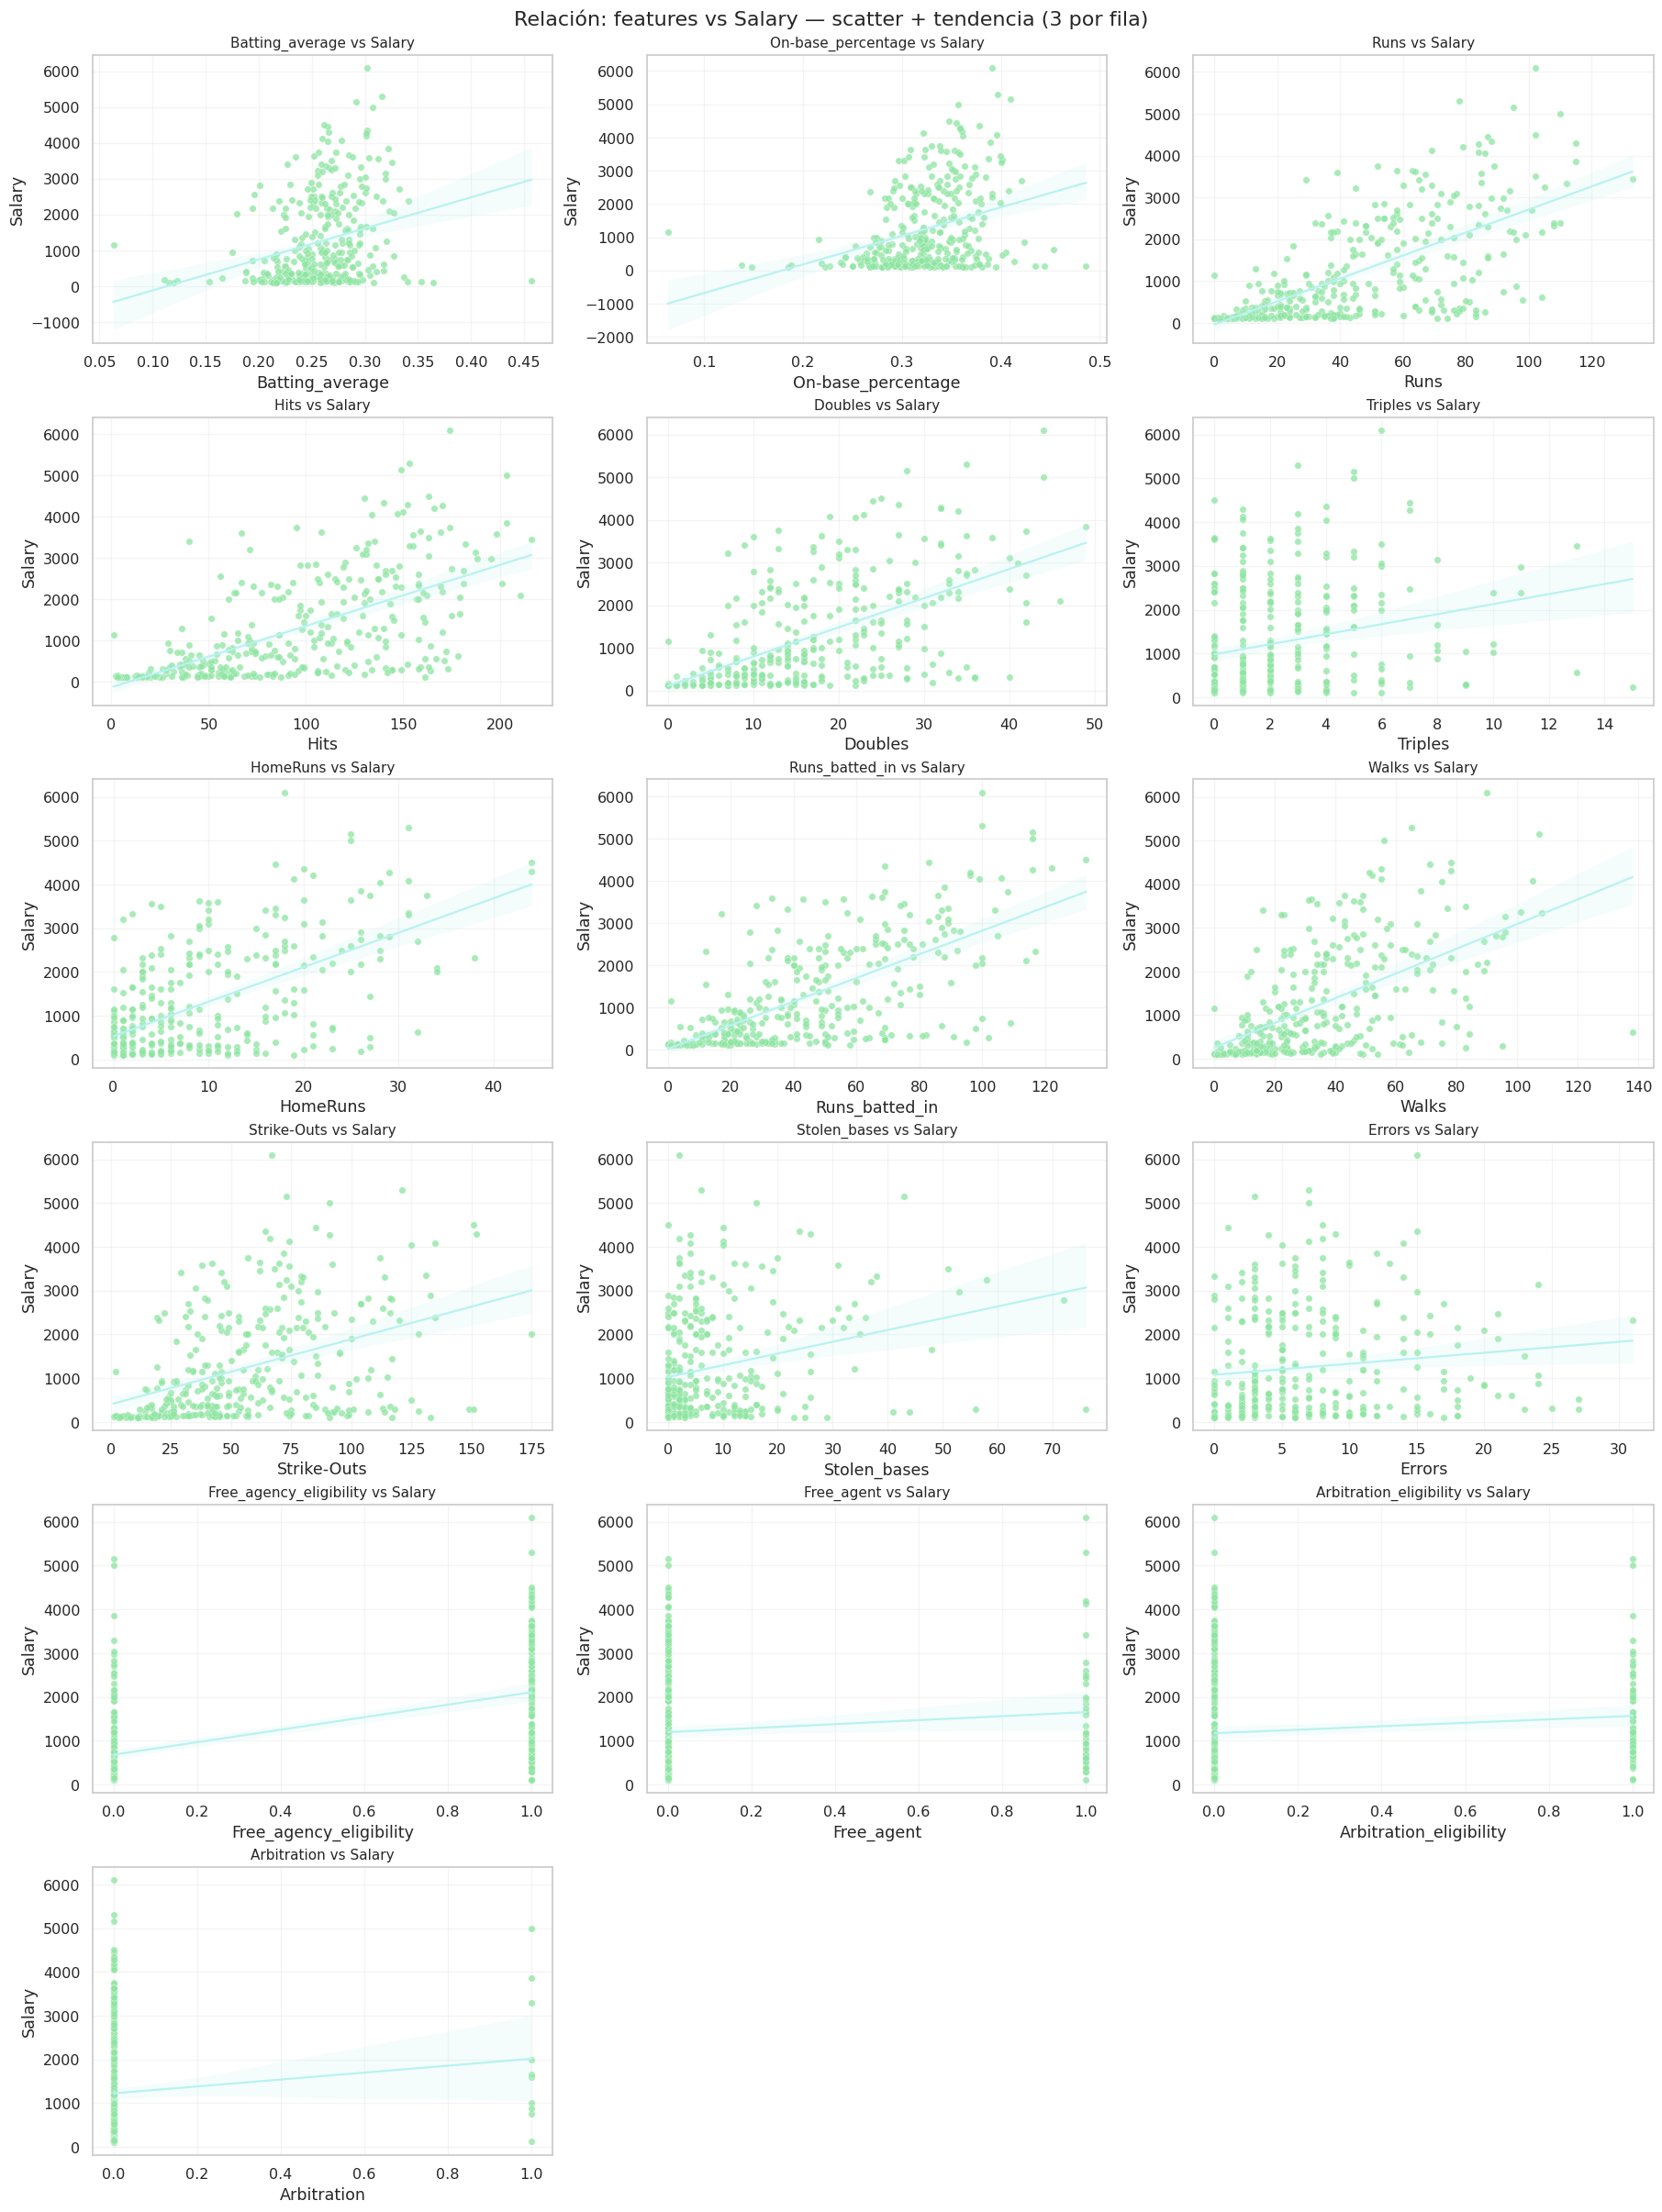

In [5]:
target = "Salary"
features = [c for c in df.columns if c != target]
n = len(features)
cols_per_row = 3
rows = math.ceil(n / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, 4*rows), constrained_layout=True)
axes = axes.flatten()

for i, feat in enumerate(features):
    ax = axes[i]
    sns.scatterplot(x=df[feat], y=df[target], ax=ax,
                    color=color_main, edgecolor="w", linewidth=0.25, s=28, alpha=0.75)
    sns.regplot(x=df[feat], y=df[target], scatter=False, ax=ax, truncate=True,
                line_kws={"linewidth":1.6, "color": color_accent})
    ax.set_title(f"{feat} vs {target}", fontsize=11)
    ax.set_xlabel(feat)
    ax.set_ylabel(target)
    ax.grid(alpha=0.2)

for j in range(n, rows*cols_per_row):
    fig.delaxes(axes[j])

fig.suptitle(f"Relación: features vs {target} — scatter + tendencia (3 por fila)", fontsize=16)
plt.show()


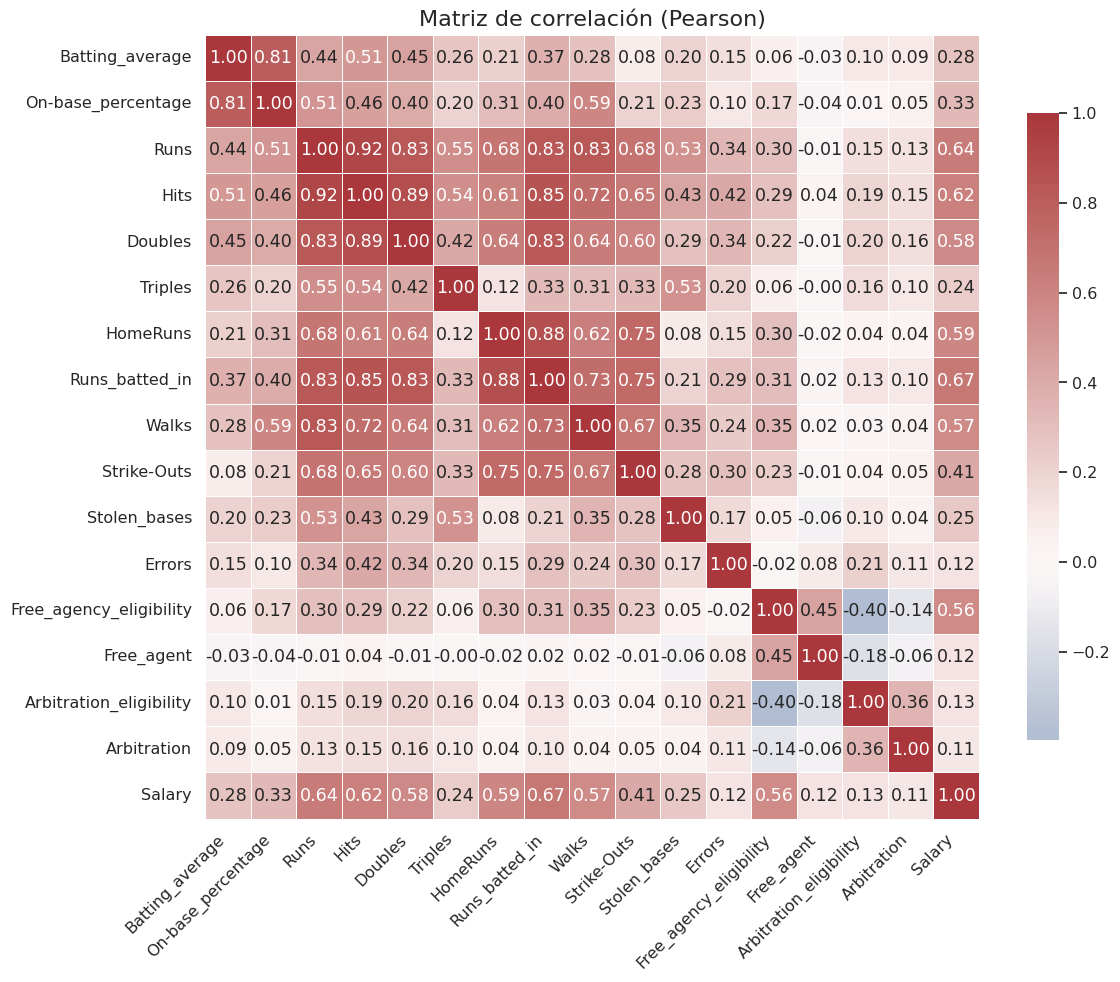


Correlación con la variable objetivo (orden descendente):


,Salary
Salary,1.000000
Runs_batted_in,0.668422
Runs,0.642903
Hits,0.621239
HomeRuns,0.590454
Doubles,0.577423
Walks,0.567085
Free_agency_eligibility,0.564586
Strike-Outs,0.405494
On-base_percentage,0.326676


In [6]:
corr = df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0, linewidths=0.5, cbar_kws={"shrink":0.8})
plt.title("Matriz de correlación (Pearson)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nCorrelación con la variable objetivo (orden descendente):")
display(corr[target].sort_values(ascending=False))





---



In [7]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

In [8]:

# Parámetros
features = df.columns.tolist()  # lista explícita

X = df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2) Ajustar LOF
lof = LocalOutlierFactor(novelty=False)
y_pred = lof.fit_predict(X_scaled)  # 1 -> inlier, -1 -> outlier
neg_lof_scores = lof.negative_outlier_factor_  # valores negativos: más negativo = más atípico
# convertimos a score positivo (cuanto mayor, más atípico)
lof_score = -neg_lof_scores

In [9]:
# Añadir columnas al DataFrame original (no escala)
df = df.copy()  # evitar modificar df original fuera del scope
df["lof_score"] = lof_score
df["is_outlier"] = y_pred == -1

# 4) Resumen rápido
n_outliers = df["is_outlier"].sum()
print(f"Total de muestras: {len(df)}")
print(f"Outliers detectados (is_outlier=True): {n_outliers}  —  Contamination usado: {20}")

# Mostrar top N más atípicos (por lof_score)
top_n = 10
print(f"\nTop {top_n} muestras más atípicas (por lof_score):")
display(df.sort_values("lof_score", ascending=False).head(top_n))

# 5) Visualizaciones: univariadas y bivariadas con outliers destacados
cols = features
n = len(cols)
cols_per_row = 3
rows = math.ceil(n / cols_per_row)

Total de muestras: 337
Outliers detectados (is_outlier=True): 18  —  Contamination usado: 20

Top 10 muestras más atípicas (por lof_score):


,Batting_average,On-base_percentage,Runs,Hits,Doubles,Triples,HomeRuns,Runs_batted_in,Walks,Strike-Outs,Stolen_bases,Errors,Free_agency_eligibility,Free_agent,Arbitration_eligibility,Arbitration,Salary,lof_score,is_outlier
179,0.063,0.063,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1150.0,2.663510,True
219,0.269,0.345,4.0,7.0,2.0,1.0,0.0,5.0,3.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,125.0,2.604325,True
202,0.457,0.486,6.0,16.0,4.0,2.0,0.0,7.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,145.0,2.352260,True
77,0.111,0.138,3.0,3.0,0.0,0.0,0.0,1.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,1.954208,True
6,0.115,0.148,0.0,3.0,1.0,0.0,0.0,2.0,1.0,6.0,0.0,3.0,0.0,0.0,0.0,0.0,109.0,1.882558,True
156,0.260,0.323,36.0,65.0,10.0,0.0,11.0,39.0,23.0,46.0,11.0,5.0,0.0,0.0,1.0,1.0,1000.0,1.756373,True
158,0.241,0.320,33.0,84.0,16.0,2.0,6.0,36.0,40.0,53.0,2.0,14.0,0.0,0.0,1.0,1.0,760.0,1.694721,True
213,0.120,0.185,0.0,3.0,0.0,0.0,0.0,1.0,2.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,109.0,1.677061,True
296,0.297,0.371,81.0,119.0,10.0,1.0,0.0,26.0,47.0,40.0,72.0,3.0,1.0,1.0,0.0,0.0,2785.0,1.637247,True
252,0.123,0.188,12.0,13.0,3.0,0.0,2.0,8.0,7.0,26.0,3.0,3.0,0.0,0.0,0.0,0.0,150.0,1.608093,True


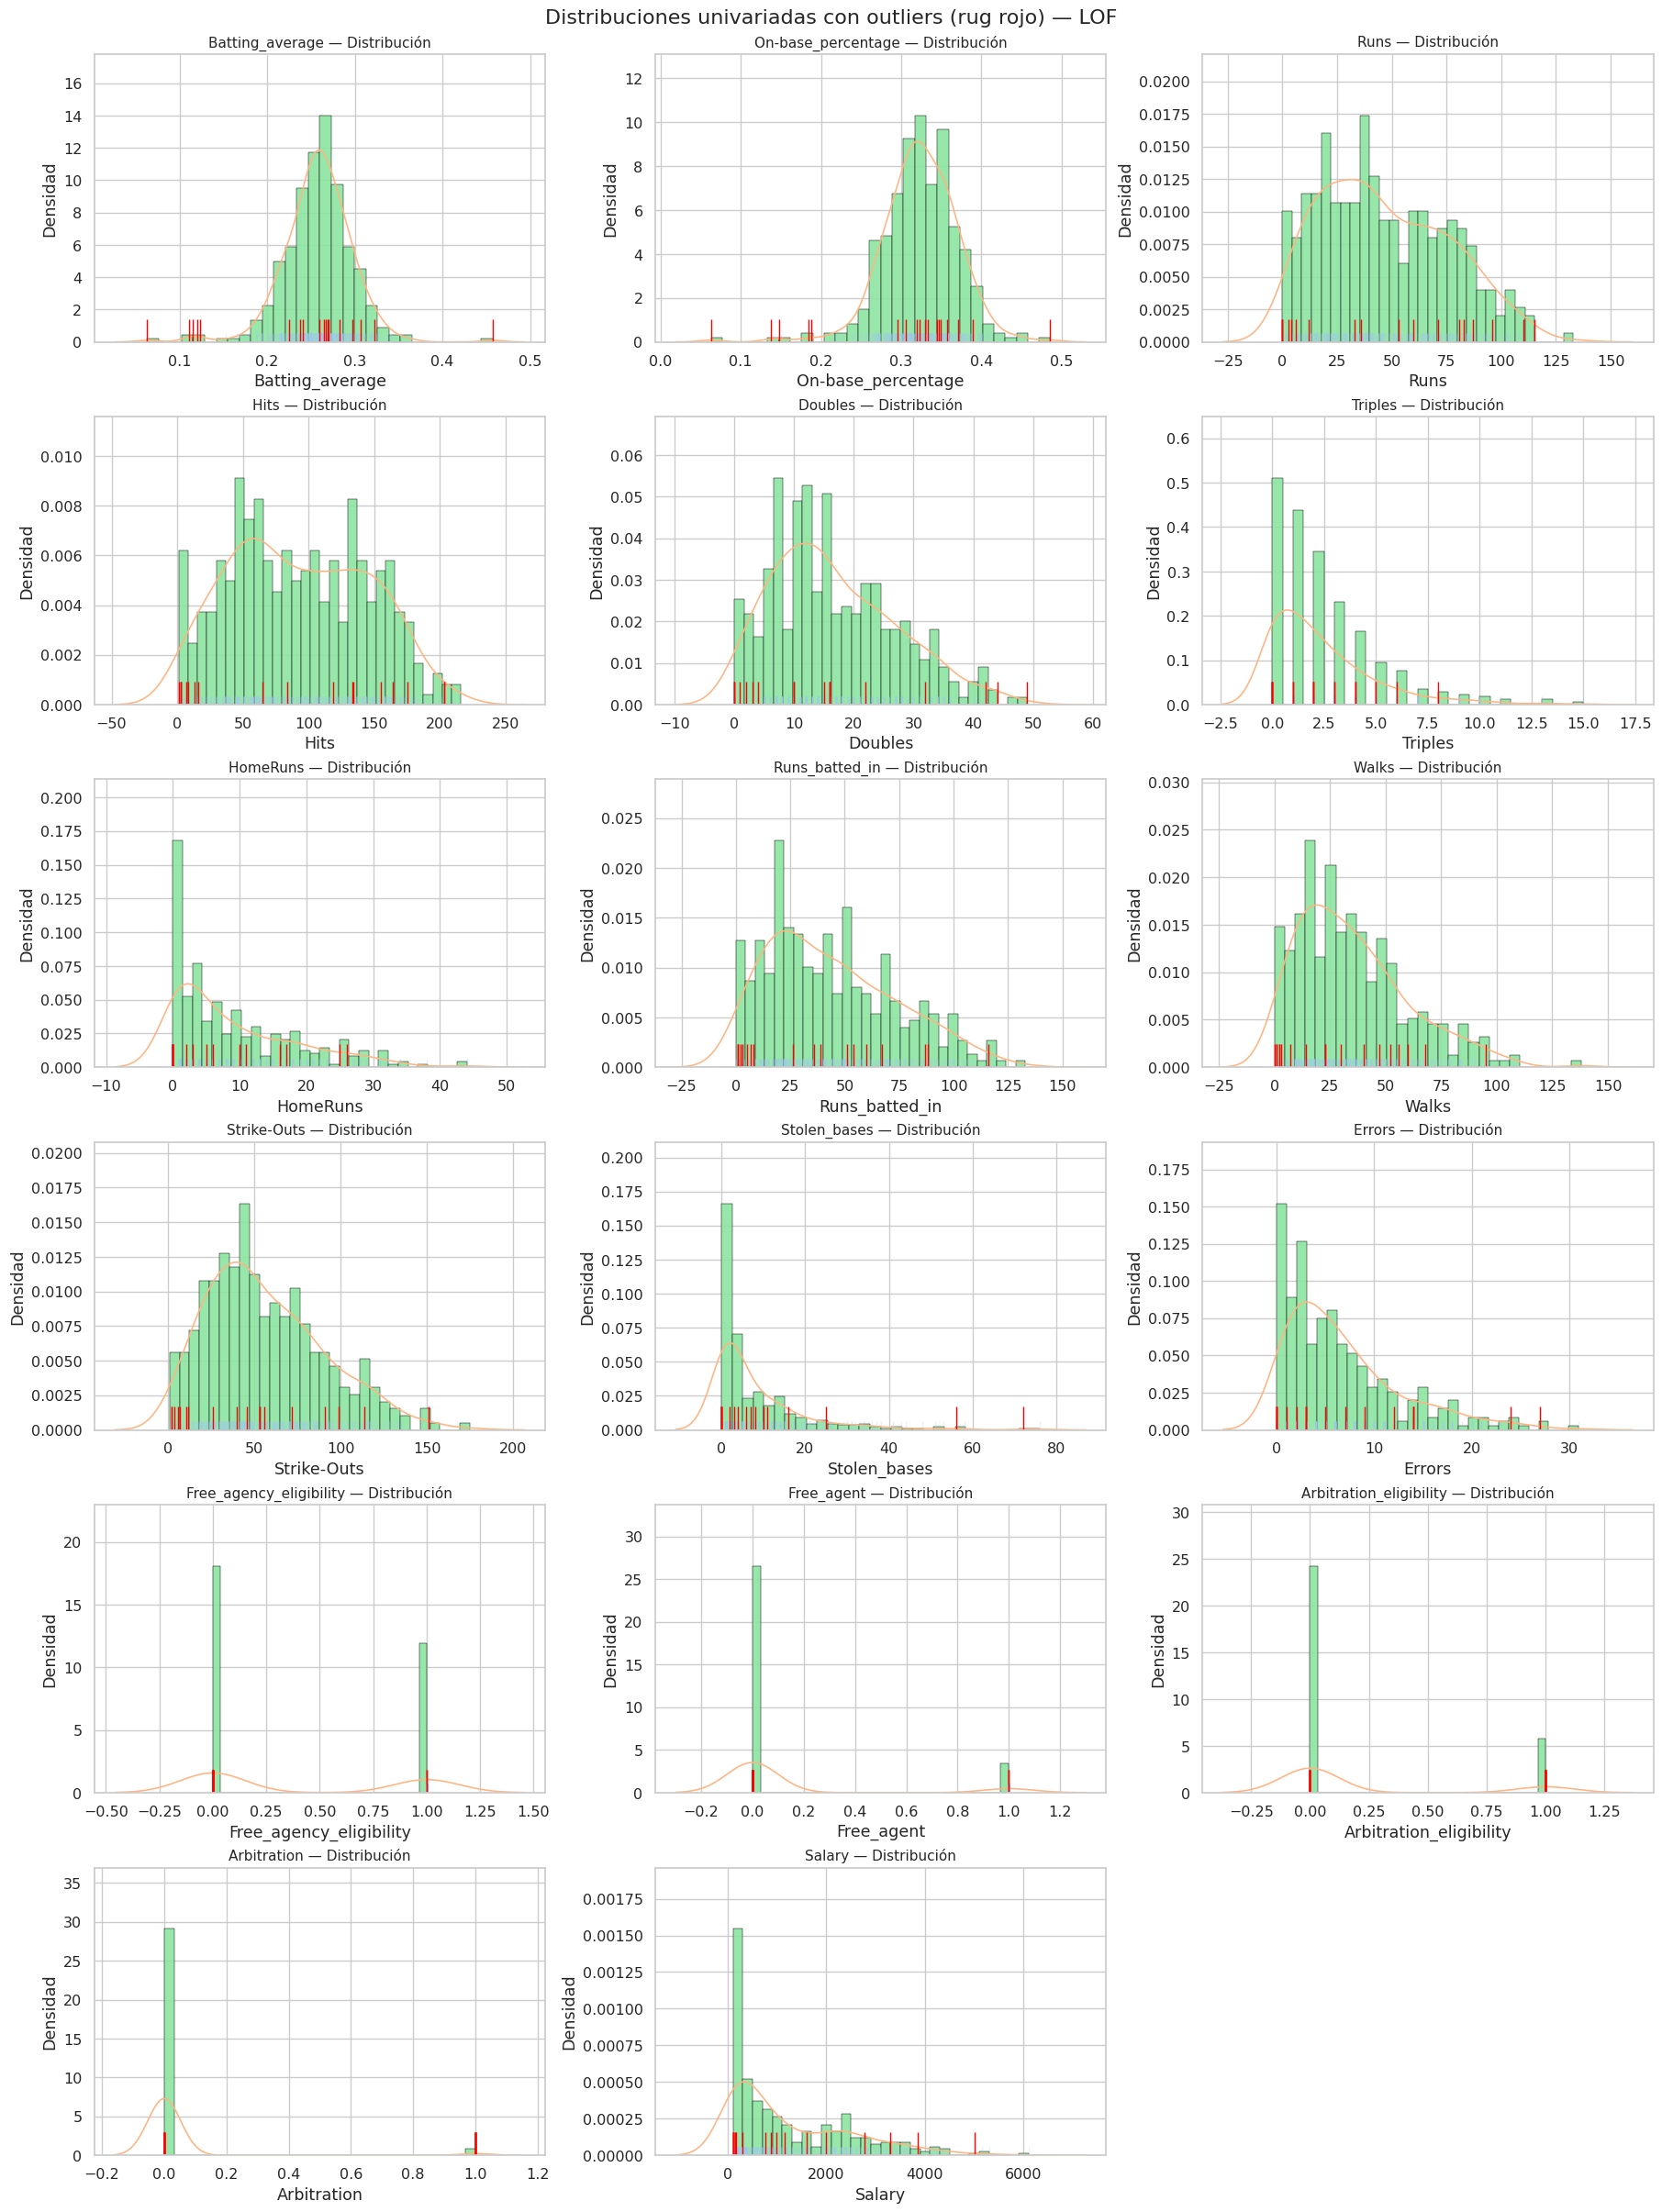

In [10]:

# Distribuciones univariadas: hist + KDE + rug con outliers en rojo
fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, 4*rows), constrained_layout=True)
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    sns.histplot(df[col], kde=False, bins=30, ax=ax, stat="density",
                 color=color_main, edgecolor="black", linewidth=0.35, alpha=0.9)
    sns.kdeplot(df[col], ax=ax, color=color_kde, linewidth=1.15, fill=False)
    ax.set_title(f"{col} — Distribución", fontsize=11)
    ax.set_ylabel("Densidad")
    # rug para inliers (sutil)
    sns.rugplot(df.loc[~df["is_outlier"], col], ax=ax, height=0.03, alpha=0.25)
    # rug para outliers (destacado en rojo)
    sns.rugplot(df.loc[df["is_outlier"], col], ax=ax, height=0.08, color="red")


for j in range(n, rows*cols_per_row):
    fig.delaxes(axes[j])

fig.suptitle("Distribuciones univariadas con outliers (rug rojo) — LOF", fontsize=16)
plt.show()

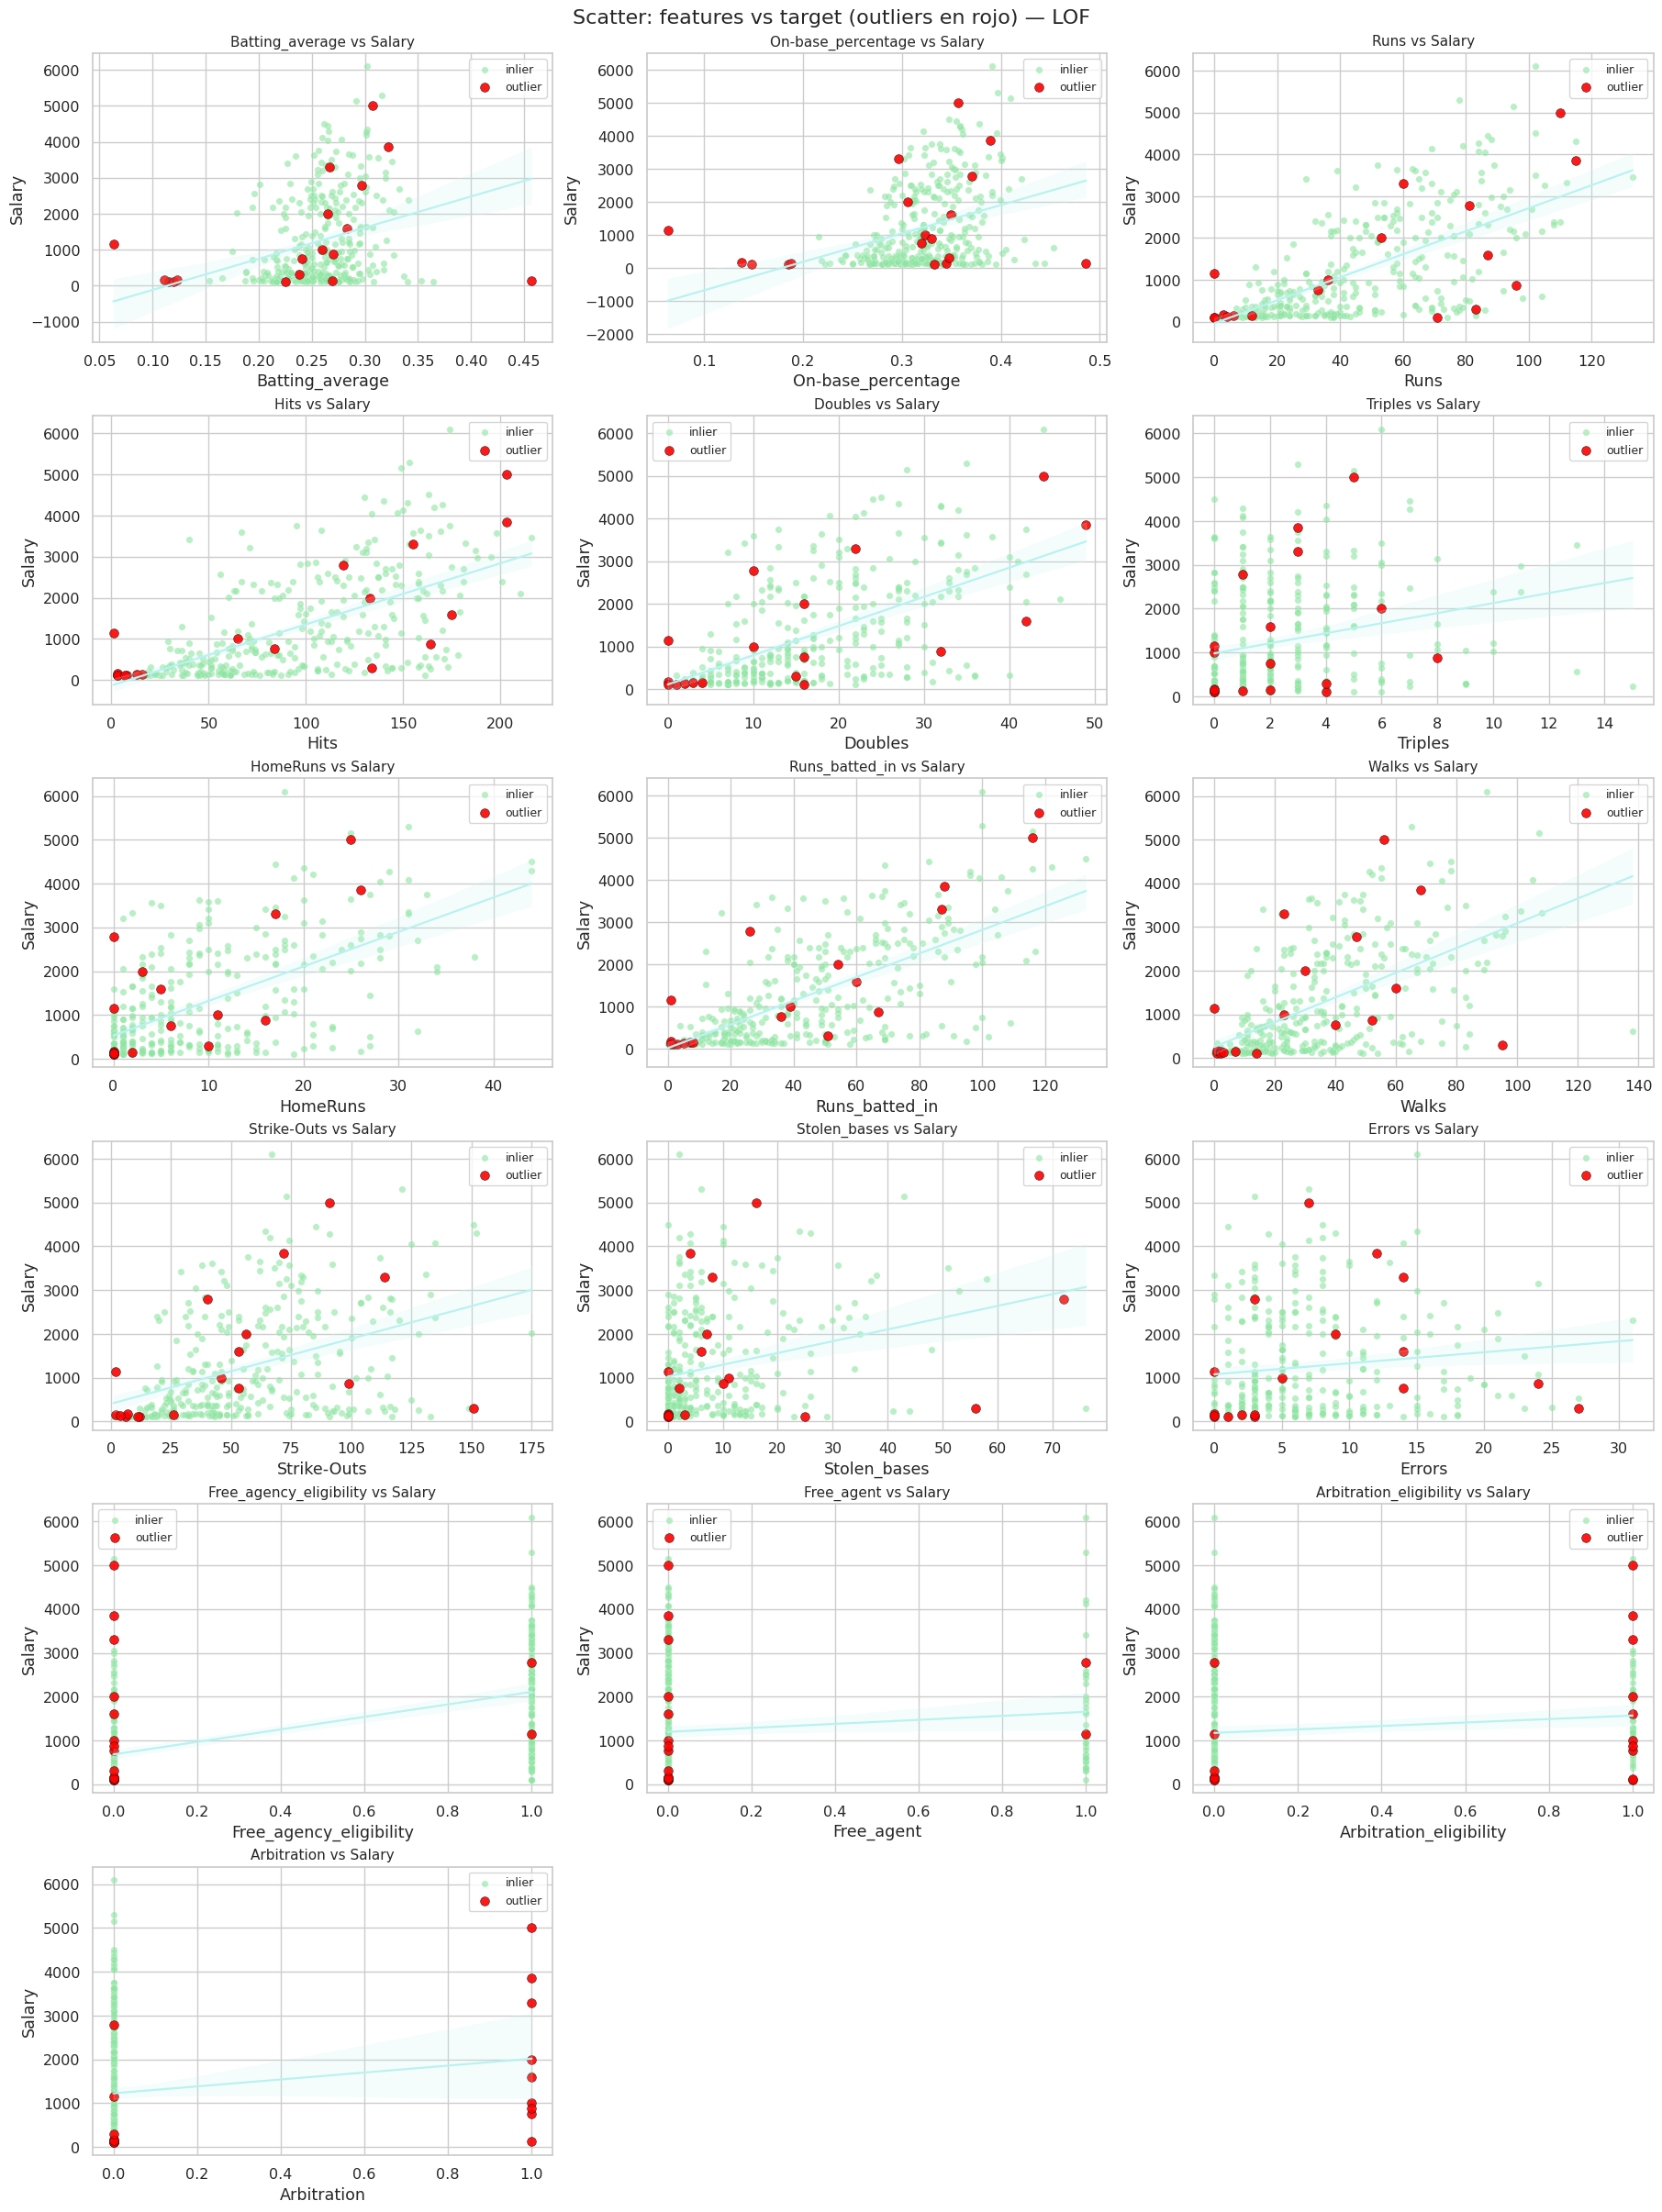

In [11]:
target = "Salary"
features_no_target = [c for c in features if c != target]
n2 = len(features_no_target)
rows2 = math.ceil(n2 / cols_per_row)

fig, axes = plt.subplots(rows2, cols_per_row, figsize=(18, 4*rows2), constrained_layout=True)
axes = axes.flatten()

for i, feat in enumerate(features_no_target):
    ax = axes[i]
    # plot inliers
    sns.scatterplot(x=df.loc[~df["is_outlier"], feat], y=df.loc[~df["is_outlier"], target],
                    ax=ax, color=color_main, s=28, alpha=0.6, edgecolor="w", linewidth=0.2, label="inlier")
    # plot outliers in red
    sns.scatterplot(x=df.loc[df["is_outlier"], feat], y=df.loc[df["is_outlier"], target],
                    ax=ax, color="red", s=50, alpha=0.9, edgecolor="k", linewidth=0.4, label="outlier")
    # tendencia sobre todos los datos
    sns.regplot(x=df[feat], y=df[target], scatter=False, ax=ax, line_kws={"color": color_accent, "linewidth":1.6})
    ax.set_title(f"{feat} vs {target}", fontsize=11)
    ax.set_xlabel(feat)
    ax.set_ylabel(target)
    ax.legend(loc="best", fontsize=9)

for j in range(n2, rows2*cols_per_row):
    fig.delaxes(axes[j])

fig.suptitle("Scatter: features vs target (outliers en rojo) — LOF", fontsize=16)
plt.show()

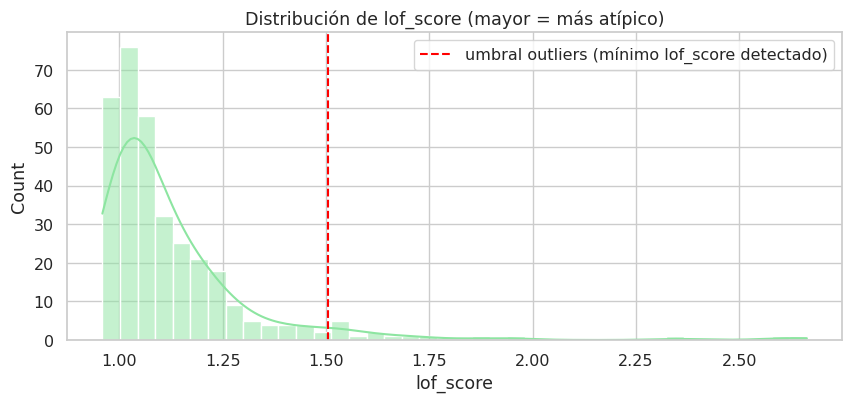

In [12]:
# Mapa de scores LOF (histograma + top outliers)
plt.figure(figsize=(10,4))
sns.histplot(df["lof_score"], bins=40, kde=True, color=color_main)
plt.title("Distribución de lof_score (mayor = más atípico)")
plt.xlabel("lof_score")
plt.axvline(df.loc[df['is_outlier'], 'lof_score'].min(), color="red", linestyle="--",
            label="umbral outliers (mínimo lof_score detectado)")
plt.legend()
plt.show()

In [13]:
import numpy as np
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, silhouette_score
from sklearn.preprocessing import StandardScaler

X = df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# --- 2. Métrica de evaluación personalizada ---
# Usaremos el coeficiente de silueta. Requiere las etiquetas y los datos.
# Un score más alto indica una mejor separación entre inliers y outliers.
def silhouette_scorer_robust(estimator, X):
    """
    Scorer de silueta robusto que maneja el caso de un solo outlier.
    """
    # fit_predict se usa aquí porque LOF en modo no-novedad
    # siempre se reajusta a los datos que va a predecir.
    labels = estimator.fit_predict(X)

    # Comprobamos que haya al menos 2 clusters (inliers y outliers) Y
    # que cada cluster tenga más de un miembro.
    if len(np.unique(labels)) < 2 or (labels == -1).sum() <= 1:
        return -1 # Devolvemos un score bajo si no se cumplen las condiciones

    return silhouette_score(X, labels)

# Convertimos la nueva función en un scorer
custom_scorer = make_scorer(silhouette_scorer_robust, greater_is_better=True)

# --- El resto de tu código sigue igual ---
# --- 3. Definición de la rejilla de hiperparámetros ---
param_grid = {
    'n_neighbors': [5, 10, 20, 35, 50],
    'contamination': [0.03, 0.05, 0.1],
    'metric': ['euclidean', 'manhattan']
}

# --- 4. Configuración y ejecución de GridSearchCV ---
lof = LocalOutlierFactor(novelty=False)
grid_search = GridSearchCV(
    estimator=lof,
    param_grid=param_grid,
    scoring=custom_scorer, # ¡Usando el nuevo scorer robusto!
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("Iniciando la búsqueda en rejilla para LOF...")
grid_search.fit(X_scaled)

# --- 5. Análisis de Resultados ---
print("\n--- ¡Búsqueda Finalizada! ---")
print(f"Mejor combinación de parámetros: {grid_search.best_params_}")
print(f"Mejor Coeficiente de Silueta: {grid_search.best_score_:.4f} ✨")

Iniciando la búsqueda en rejilla para LOF...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

--- ¡Búsqueda Finalizada! ---
Mejor combinación de parámetros: {'contamination': 0.03, 'metric': 'euclidean', 'n_neighbors': 5}
Mejor Coeficiente de Silueta: nan ✨


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [18]:
import pandas as pd
import numpy as np
from itertools import product
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler


X = df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# 1. Define la rejilla completa de hiperparámetros
neighbors_grid = [5, 10, 20, 35, 50]
contamination_grid = [0.03, 0.05, 0.1] # Usando valores que evitan el caso de 1 outlier
metric_grid = ['euclidean', 'manhattan']

results = []

print("Iniciando búsqueda manual en rejilla...")

for n_neighbors, contamination, metric in product(neighbors_grid, contamination_grid, metric_grid):

    # Crea la instancia de LOF con la combinación actual
    lof = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination=contamination,
        metric=metric,
        novelty=False
    )

    # Ajusta y predice
    y_pred = lof.fit_predict(X_scaled)

    # Calcula las métricas
    lof_score = -lof.negative_outlier_factor_
    n_outliers = (y_pred == -1).sum()

    # Calcula el score medio solo si se encontraron outliers
    mean_lof = lof_score[y_pred == -1].mean() if n_outliers > 0 else 0.0

    # Guarda los resultados
    results.append({
        "n_neighbors": n_neighbors,
        "contamination": contamination,
        "metric": metric,
        "n_outliers": n_outliers,
        "mean_lof_score": mean_lof
    })

print("¡Búsqueda finalizada!")

df_grid = pd.DataFrame(results)


df_grid_sorted = df_grid.sort_values(by="mean_lof_score", ascending=False).reset_index(drop=True)

print("\n--- Top 5 Mejores Combinaciones (según Mean LOF Score) ---")
display(df_grid_sorted.head())

Iniciando búsqueda manual en rejilla...
¡Búsqueda finalizada!

--- Top 5 Mejores Combinaciones (según Mean LOF Score) ---


,n_neighbors,contamination,metric,n_outliers,mean_lof_score
0,20,0.03,euclidean,11,1.944964
1,35,0.03,euclidean,11,1.915979
2,50,0.03,euclidean,11,1.881338
3,5,0.03,manhattan,11,1.863043
4,10,0.03,manhattan,11,1.815968


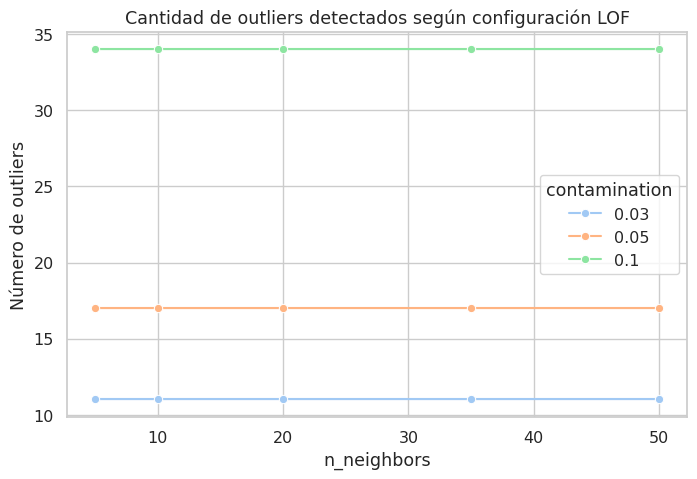

In [16]:
plt.figure(figsize=(8,5))
sns.lineplot(data=df_grid, x="n_neighbors", y="n_outliers",
             hue="contamination", marker="o", palette="pastel")
plt.title("Cantidad de outliers detectados según configuración LOF")
plt.ylabel("Número de outliers")
plt.xlabel("n_neighbors")
plt.legend(title="contamination")
plt.show()


In [17]:
# Crear un DataFrame limpio sin outliers
df_clean = df[~df["is_outlier"]].copy()

print(f"Dataset original: {df.shape[0]} filas")
print(f"Outliers eliminados: {df['is_outlier'].sum()}")
print(f"Dataset limpio: {df_clean.shape[0]} filas")

# Vista rápida de los primeros registros
display(df_clean.head())


Dataset original: 337 filas
Outliers eliminados: 18
Dataset limpio: 319 filas


,Batting_average,On-base_percentage,Runs,Hits,Doubles,Triples,HomeRuns,Runs_batted_in,Walks,Strike-Outs,Stolen_bases,Errors,Free_agency_eligibility,Free_agent,Arbitration_eligibility,Arbitration,Salary,lof_score,is_outlier
0,0.271,0.328,74.0,161.0,22.0,6.0,12.0,58.0,49.0,133.0,23.0,17.0,1.0,1.0,0.0,0.0,109.0,1.219400,False
1,0.264,0.318,24.0,48.0,7.0,0.0,1.0,22.0,15.0,18.0,0.0,7.0,0.0,0.0,0.0,0.0,160.0,0.985476,False
2,0.251,0.338,101.0,141.0,35.0,3.0,32.0,105.0,71.0,104.0,34.0,6.0,0.0,0.0,1.0,0.0,2700.0,1.174894,False
3,0.224,0.274,28.0,94.0,21.0,1.0,1.0,44.0,27.0,54.0,2.0,7.0,1.0,1.0,0.0,0.0,550.0,0.994884,False
4,0.206,0.262,14.0,51.0,18.0,1.0,1.0,28.0,17.0,26.0,0.0,3.0,1.0,1.0,0.0,0.0,300.0,1.066415,False


In [ ]:
df_clean.to_csv("baseball_cleanLOF.csv", index=False)